#Sentiment Analysis for Tweets
Finding if a person is depressed from their use of words on social media

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from wordcloud import WordCloud
import re
import nltk 
from bs4 import BeautifulSoup
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/NLP/NLP_FinalProject/sentiment_tweets3.csv')
df

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1


In [ ]:
df.drop('Index',axis=1,inplace=True)
df.rename({'label (depression result)':'label','message to examine':'text'},axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10314 non-null  object
 1   label   10314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB


In [ ]:
df

,text,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


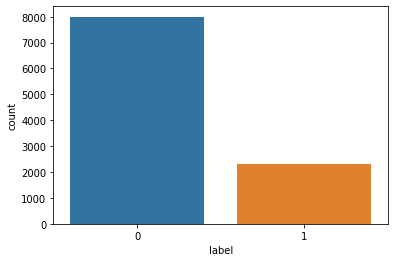

In [ ]:
sns.countplot(df.label)
plt.show()

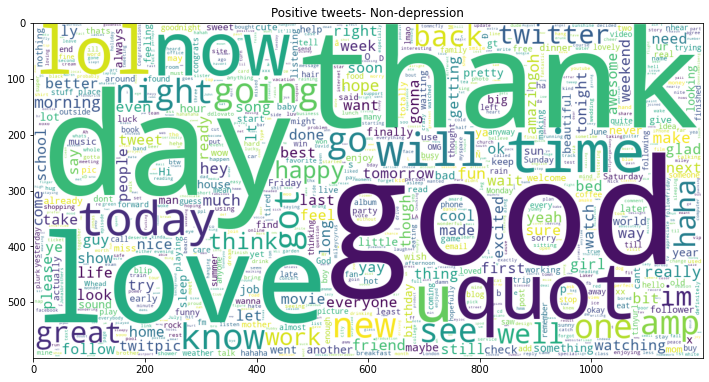

In [ ]:
#wordcloud for the case "non-depression"
wc = WordCloud(background_color='white', max_words = 1000 , width = 1200 , height = 600, 
               collocations=False).generate(" ".join(df[df['label']==0]['text']))
plt.figure(figsize = (12,12))
plt.title("Positive tweets- Non-depression")
plt.imshow(wc)

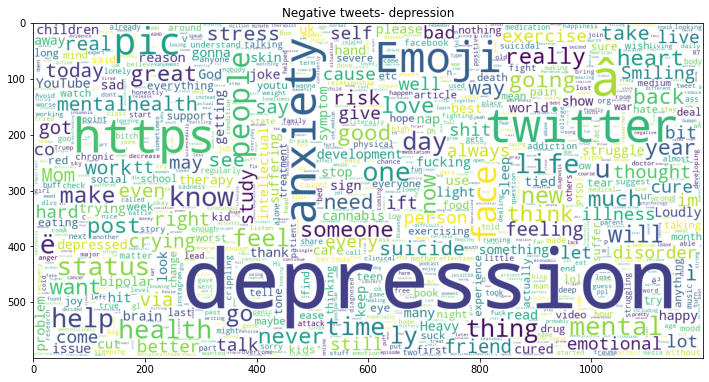

In [ ]:
#wordcloud for the case "depression"
wc = WordCloud(background_color='white', max_words = 1000 , width = 1200 , height = 600, 
               collocations=False).generate(" ".join(df[df['label']==1]['text']))
plt.figure(figsize = (12,12))
plt.title("Negative tweets- depression")
plt.imshow(wc)

In [ ]:
df.label.value_counts()

0    8000
1    2314
Name: label, dtype: int64

The dataset is not balanced.

We can do downsampling on the majority class to obtain a balanced dataset.

In [ ]:
df_z = df[df.label==0]
df_o = df[df.label==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_z, 
                                 replace=False,    # sample without replacement
                                 n_samples=2300,     # to approximately match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_o])
df_downsampled.reset_index(drop=True, inplace=True)
df_downsampled

,text,label
0,the oc http://mypict.me/1ord,0
1,getting my new car on monday yay me !!,0
2,@princess_narnia I heat! I want a full shoppi...,0
3,@macster7 this a relief! Hahah. Telling my gri...,0
4,Quick Question Is Fortune And Fame To Much To ...,0
...,...,...
4609,No Depression by G Herbo is my mood from now o...,1
4610,What do you do when depression succumbs the br...,1
4611,Ketamine Nasal Spray Shows Promise Against Dep...,1
4612,dont mistake a bad day with depression! everyo...,1


In [ ]:
df_downsampled.label.value_counts()

1    2314
0    2300
Name: label, dtype: int64

BeautifulSoup object is provided by Beautiful Soup which is a web scraping framework for Python. Web scraping is the process of extracting data from the website using automated tools to make the process faster. The BeautifulSoup object represents the parsed document as a whole

In [ ]:
# cleaning the tweets
#nltk.download('omw-1.4')
nltk.download('all')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_?!]')
regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
#for textual emoji
emoticon_string = r"""
(?:
[<>]?
[:;=8] #eyes
[\-o\*\']? #optional nose
[\)\]\(\[dDpP/\:\}\{@\|\\] #mouth
|
[\)\]\(\[dDpP/\:\}\{@\|\\] #mouth
[\-o\*\']? #optional nose
[:;=8] #eyes
[<>]?
)"""


def clean_text(text):
    url_regex ='((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*'

    text = text.lower()
    text = BeautifulSoup(text,'lxml').text      
    text = re.sub(url_regex,' ',text)


    text = re.sub('@(\w)+','  ',text)
    text = re.sub('#(\w)+','  ',text)
    text = re.sub('(\r)+',' ',text)       #carriage return character
    text = re.sub('(\n)+',' ',text)       # new line character
    
    text = re.sub('(\?)+',' ',text)
    text = re.sub('(\.)+',' ',text)

    #remove textual emoji
    text = re.sub(emoticon_string, '', text)

    text = re.sub('\'','',text) 
    text = re.sub('https*',' ',text) 
    text = re.sub('!+','  ',text)    
    text = re.sub(':\(',' sad ',text)
    text = re.sub(':\)',' happy ',text)
    text = re.sub('/+',' ',text)
    text = re.sub('\|+',' ',text)

    symbol = ['â\x97','â\x85','â\x92','â\x92','â\x92t','Â\x93','Â\x85',
        'Â\x96','Â\x92','Â\x94','â\x93','â\x91','â\x94','â\x96','â','â·','\x80']

    for i in symbol:
        text = re.sub(i,' ',text)

    english_stop_words = nltk.corpus.stopwords.words('english')
    tokenizer = nltk.tokenize.word_tokenize
    text = " ".join([word for word in tokenizer(text) if word not in english_stop_words ])

    # PorterStemmer
    porter = nltk.stem.PorterStemmer()    # to get the stem of the words
    text = " ".join([porter.stem(word) for word in tokenizer(text)])
    
    # lematizer
    lematizer = nltk.stem.WordNetLemmatizer()   # for lemmatization
    text = " ".join([lematizer.lemmatize(word) for word in tokenizer(text)])
    
    text = re.sub('\s+',' ',text)     #whitespace character
    
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    
    text = regex.sub(' ', text)
    text = text.strip()
    text= ' '.join(text.split())
    return text 

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

In [ ]:
df['text_clean'] = df['text'].apply(clean_text)
df

,text,label,text_clean
0,just had a real good moment. i missssssssss hi...,0,real good moment miss much
1,is reading manga http://plurk.com/p/mzp1e,0,read manga
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,
3,@lapcat Need to send 'em to my accountant tomo...,0,need send em account tomorrow oddli wasnt even...
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,add myspac
...,...,...,...
10309,No Depression by G Herbo is my mood from now o...,1,depress g herbo mood im done stress peopl dont...
10310,What do you do when depression succumbs the br...,1,depress succumb brain make feel like youll nev...
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1,ketamin nasal spray show promis depress suicid
10312,dont mistake a bad day with depression! everyo...,1,dont mistak bad day depress everyon em


In [ ]:
df_downsampled['text_clean'] = df_downsampled['text'].apply(clean_text)
df_downsampled

,text,label,text_clean
0,the oc http://mypict.me/1ord,0,oc
1,getting my new car on monday yay me !!,0,get new car monday yay
2,@princess_narnia I heat! I want a full shoppi...,0,heat want full shop report k squeee
3,@macster7 this a relief! Hahah. Telling my gri...,0,relief hahah tell grievanc someon hahah thank ...
4,Quick Question Is Fortune And Fame To Much To ...,0,quick question fortun fame much ask repli
...,...,...,...
4609,No Depression by G Herbo is my mood from now o...,1,depress g herbo mood im done stress peopl dont...
4610,What do you do when depression succumbs the br...,1,depress succumb brain make feel like youll nev...
4611,Ketamine Nasal Spray Shows Promise Against Dep...,1,ketamin nasal spray show promis depress suicid
4612,dont mistake a bad day with depression! everyo...,1,dont mistak bad day depress everyon em


In [ ]:
print("Before:")
print(df_downsampled['text'][7])
print("After:")
print(df_downsampled['text_clean'][7])

Before:
@kathyIreland Hugs 4 kathy. Though my mom's in heaven, I know she's smiling at my accomplishments &amp; all the people who keep me positive. 
After:
hug kathi though mom heaven know she smile accomplish peopl keep posit


In [ ]:
# finding empty cells after cleaning
df_downsampled[df_downsampled['text_clean'] == ''].index

Int64Index([  71,  251,  259,  398,  995, 1184, 1213, 1280, 1469, 2055, 2267,
            3334, 3883, 3906, 4004, 4018, 4497, 4613],
           dtype='int64')

In [ ]:
#removing empty cells after cleaning
df_downsampled['text_clean'].replace('', np.nan, inplace=True)
df_downsampled= df_downsampled.dropna(subset=['text_clean'])
df_downsampled.reset_index(drop=True, inplace=True)
df_downsampled

,text,label,text_clean
0,the oc http://mypict.me/1ord,0,oc
1,getting my new car on monday yay me !!,0,get new car monday yay
2,@princess_narnia I heat! I want a full shoppi...,0,heat want full shop report k squeee
3,@macster7 this a relief! Hahah. Telling my gri...,0,relief hahah tell grievanc someon hahah thank ...
4,Quick Question Is Fortune And Fame To Much To ...,0,quick question fortun fame much ask repli
...,...,...,...
4591,Many sufferers of depression aren't sad; they ...,1,mani suffer depress arent sad feel noth persis...
4592,No Depression by G Herbo is my mood from now o...,1,depress g herbo mood im done stress peopl dont...
4593,What do you do when depression succumbs the br...,1,depress succumb brain make feel like youll nev...
4594,Ketamine Nasal Spray Shows Promise Against Dep...,1,ketamin nasal spray show promis depress suicid


# N-grams

In [ ]:
tfidf_vectorizer_uni = TfidfVectorizer(analyzer='word',
                                   min_df=0.001,
                                   max_df=0.75,
                                   stop_words='english',
                                   sublinear_tf=True,
                                   ngram_range=(1,1)
                                     )

X = tfidf_vectorizer_uni.fit_transform(df_downsampled['text_clean'])

vectorizer_uni = CountVectorizer(analyzer='word', min_df=0.001, max_df=0.75, stop_words='english', ngram_range=(1,1))

X2 = vectorizer_uni.fit_transform(df_downsampled['text_clean'])

In [ ]:
df_uni = pd.DataFrame(data={'word': vectorizer_uni.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1,     #sum of columns
                        'idf': tfidf_vectorizer_uni.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_uni = df_uni.sort_values(['tfidf', 'tf', 'idf'], ascending=False)  # sorted by on tf-idf
df_uni[:10]

,word,tf,idf,tfidf
292,depress,2233,1.779664,337.807401
555,im,508,3.312862,116.632135
661,love,299,3.791252,90.107526
49,anxieti,338,3.652416,80.716458
638,like,324,3.729377,79.811210
274,day,277,3.872478,78.406171
1121,thank,186,4.229153,76.045954
472,good,251,3.977838,75.440302
609,know,233,4.053262,61.221955
1137,time,217,4.095621,60.750047


In [ ]:
tfidf_vectorizer_bi = TfidfVectorizer(analyzer='word',
                                   min_df=0.001,
                                   max_df=0.75,
                                   stop_words='english',
                                   sublinear_tf=True,
                                   ngram_range=(2,2)
                                     )

X = tfidf_vectorizer_bi.fit_transform(df_downsampled['text_clean'])

vectorizer_bi = CountVectorizer(analyzer='word', min_df=0.001, max_df=0.75, stop_words='english', ngram_range=(2,2))

X2 = vectorizer_bi.fit_transform(df_downsampled['text_clean'])

In [ ]:
df_bi = pd.DataFrame(data={'word': vectorizer_bi.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1,     #sum of columns
                        'idf': tfidf_vectorizer_bi.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_bi = df_bi.sort_values(['tfidf', 'tf', 'idf'], ascending=False)  # sorted by on tf-idf
df_bi[:10]

,word,tf,idf,tfidf
38,depress anxieti,129,4.565625,95.326352
4,anxieti depress,131,4.565625,93.825473
25,cure depress,52,5.462867,48.657695
140,gon na,65,5.306025,44.542782
219,mental health,55,5.481915,34.198251
152,great depress,35,5.877811,30.992298
81,depress nap,35,5.849640,29.934071
303,wan na,36,5.849640,26.805891
116,dont know,32,5.967423,21.430549
278,suffer depress,30,5.999172,21.377647


In [ ]:
tfidf_vectorizer_tri = TfidfVectorizer(analyzer='word',
                                   min_df=0.001,
                                   max_df=0.75,
                                   stop_words='english',
                                   sublinear_tf=True,
                                   ngram_range=(3,3)
                                     )

X = tfidf_vectorizer_tri.fit_transform(df_downsampled['text_clean'])

vectorizer_tri = CountVectorizer(analyzer='word', min_df=0.001, max_df=0.75, stop_words='english', ngram_range=(3,3))

X2 = vectorizer_tri.fit_transform(df_downsampled['text_clean'])

In [ ]:
df_tri = pd.DataFrame(data={'word': vectorizer_tri.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1,     #sum of columns
                        'idf': tfidf_vectorizer_tri.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_tri = df_tri.sort_values(['tfidf', 'tf', 'idf'], ascending=False)  # sorted by on tf-idf
df_tri[:10]

,word,tf,idf,tfidf
29,im gon na,21,6.342117,21.000000
18,depress tie kid,31,5.967423,13.863621
21,emot intellectu develop,31,5.967423,13.863621
31,kid emot intellectu,31,5.967423,13.863621
36,mom depress tie,31,5.967423,13.863621
47,tie kid emot,31,5.967423,13.863621
5,cannabi ea depress,17,6.542787,10.607038
39,puff cannabi ea,16,6.599946,10.166031
14,depress mental ill,8,7.235935,8.000000
27,happi mother day,8,7.235935,8.000000


Extract the top collocations for the Twitter data

In [ ]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
from collections import Counter

#stopwords_ = set(stopwords.words('english'))

words = [word for document in df_downsampled['text_clean'] for word in document.split() 
         if len(word) > 2]
         
finder = BigramCollocationFinder.from_words(words)
bgm = BigramAssocMeasures()
score = bgm.mi_like         # mutual information like
collocations = {'_'.join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)}
collocations         # there is no threshould for pmi

{'mental_health': 17.47636554621849,
 'intellectu_develop': 15.779131355932204,
 'emot_intellectu': 15.516145833333333,
 'tie_kid': 12.731196581196581,
 'puff_cannabi': 12.2825,
 'cant_wait': 8.170661157024794,
 'ist_saddepress': 8.0,
 'kid_emot': 7.638717948717948,
 'choicedepress_choicedepress': 6.320987654320987,
 'saddepress_ist': 5.359375,
 'feder_reserv': 4.5,
 'ice_cream': 4.454545454545454,
 'deepika_padukon': 3.5714285714285716,
 'harri_potter': 3.5714285714285716,
 'depress_anxieti': 3.117091131679991,
 'anxieti_depress': 3.0473081295362463,
 'reserve_caused': 3.0,
 'chemic_imbal': 2.9761904761904763,
 'mental_ill': 2.761036809089833,
 'kelli_clarkson': 2.25,
 'regularli_cut': 2.25,
 'panic_attack': 2.178649237472767,
 'gsk_catenin': 2.0,
 'modul_gsk': 2.0,
 'prospect_cohort': 2.0,
 'ronaldo_fanboy': 2.0,
 'vern_troyer': 2.0,
 'wreak_havoc': 2.0,
 'pay_vip': 1.9055555555555554,
 'cut_risk': 1.8493265993265993,
 'harm_phrase': 1.815126050420168,
 'bateman_lectur': 1.8,
 'ketam

# Train and test split

In [ ]:
#train 80%, test 20%
#df_train = df_downsampled.sample(frac=0.8)
#df_droptrain = df_downsampled.drop(df_train.index)
#df_test = df_droptrain.sample(frac=0.2)


#train 70%, test 20%, valid 10%
df_train = df_downsampled.sample(frac=0.7)
df_droptrain = df_downsampled.drop(df_train.index)

df_test = df_droptrain.sample(frac=0.2)
df_droptrain_droptest = df_droptrain.drop(df_test.index)

df_valid= df_droptrain_droptest.sample(frac=0.1)    # we need validation data for BERT

In [ ]:
df_train

,text,label,text_clean
1393,At the bubble house again,0,bubbl hous
2936,I'm Forgot all my problems and depression when...,1,im forgot problem depress your
1880,so far so good! http://tinyurl.com/rae6zy,0,far good
505,Raining. Got @ddlovato on repeat. This day cou...,0,rain got repeat day couldnt get better wait ke...
869,I just dyededed my hair,0,dyeded hair
...,...,...,...
97,@frezned i think you should Burritos are WIN!,0,think burrito win
1333,"@ericdot mine was 44GB, you broke my record",0,mine gb broke record
4444,"That hard beat of your heart, the endless doub...",1,hard beat heart endless doubt yearn somebodi c...
2791,when you had a good day but the depression kic...,1,good day depress kick drag hole loneli sad


In [ ]:
df_test

,text,label,text_clean
3228,How you look at all the incoming freshman exci...,1,look incom freshman excit colleg know clue joi...
3293,Transparent moment: I sometimes go through spu...,1,transpar moment sometim go spurt struggl feel ...
951,Taking lunch break. Great rehearsal,0,take lunch break great rehears
81,Good morning tweeps! Day 2 begins now! Wish me...,0,good morn tweep day begin wish luck
609,Good Morning peeps!,0,good morn peep
...,...,...,...
2278,is off to bed. Ready for cut and colour tomorrow,0,bed readi cut colour tomorrow
2427,went into depression mode for ab 5 months.. gl...,1,went depress mode ab month glad im better swea...
4096,Depression is real,1,depress real
4528,"AAAHHHH SUCH HYPOCRISY. Please, gurl. Bakit mo...",1,aaahhhh hypocrisi plea gurl bakit mo dinadamay...


In [ ]:
df_valid

,text,label,text_clean
2291,depression is something i don't speak about ev...,1,depress someth dont speak even go also doubl e...
4476,Things I never imagined doing: researching dog...,1,thing never imagin research dog anxieti depres...
4474,i dont think my trauma from when i was like 2 ...,1,dont think trauma like gna get better help mom...
954,@ricacupcakes I didn't see it lol it was sold ...,0,didnt see lol sold ate pink taco
3373,i cooked. depression where?,1,cook depress
...,...,...,...
716,@elleashley hewo Ellie Berry Sho cute wor the...,0,hewo elli berri sho cute wor name
4488,its amazing how depression can take any rare f...,1,amaz depress take rare fleet posit moment make...
2385,can i just post this picture everyday pleaseit...,1,post pictur everyday pleaseit help ea away dep...
3774,@MonmouthFF I've already submitted THE BATEMAN...,1,ive alreadi submit bateman lectur depress hope...


# Logistic Regression

In [ ]:
Y= df_train['label']


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.75, 
                             #max_features= 10000 ,
                             stop_words='english')

X = vectorizer.fit_transform(df_train['text_clean']) # doc-features matrix
print(X.shape)     # if the number of features is high. is better to cut them e.g by defigning max_feature="" in vectorizer

(3217, 1479)


In [ ]:
vectorizer.vocabulary_['depress']  # column index for the word "depress"

328

How often the word "depress" is in the dataset:

In [ ]:
df_downsampled[df_downsampled.text_clean.str.contains(' depress ')]

,text,label,text_clean
2289,The lack of this understanding is a small but ...,1,lack understand small signific part caus anxie...
2290,i just told my parents about my depression and...,1,told parent depress hard get gen x peopl under...
2292,Made myself a tortilla filled with pb&j. My de...,1,made tortilla fill pb j depress cure olivia de...
2293,@WorldofOutlaws I am gonna need depression med...,1,gon na need depress med soon rainout spin equi...
2294,my anxiety and my depression fighting over who...,1,anxieti depress fight who day
...,...,...,...
4588,RT Depression Could Be Improved With Vitamin D...,1,rt depress could improv vitamin defici treatment
4589,actors symptoms of adult depression naked gtee...,1,actor symptom adult depress nake gteen porn bl...
4591,Many sufferers of depression aren't sad; they ...,1,mani suffer depress arent sad feel noth persis...
4594,Ketamine Nasal Spray Shows Promise Against Dep...,1,ketamin nasal spray show promis depress suicid


In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(n_jobs=-1, class_weight='balanced')
%time classifier.fit(X, Y)
print(classifier)

CPU times: user 31.2 ms, sys: 215 ms, total: 246 ms
Wall time: 1.61 s
LogisticRegression(class_weight='balanced', n_jobs=-1)


In [ ]:
classifier.coef_.shape

(1, 1479)

Coefficients for the two words "depress" and "good" are shown bellow.
positive value indicates the class 1 (depression) and negative value the class 0 (no depression).

In [ ]:
k = vectorizer.vocabulary_['depress'] # column position for the word
print(vectorizer.get_feature_names()[k], classifier.coef_[0, k])

depress 19.163509986450407


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
k = vectorizer.vocabulary_['good'] # column position for the word
print(vectorizer.get_feature_names()[k], classifier.coef_[0, k])

good -1.2108455105878335


Trying the model on test dataset:

In [ ]:
Y_test = df_test['label']
X_test = vectorizer.transform(df_test['text_clean'])  # not fit_transform

# use the old classifier to predict and evaluate
new_predictions = classifier.predict(X_test)
print(new_predictions)

[1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1
 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0
 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1
 1 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1
 1 0 0 1 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0
 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0
 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1]


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       143
           1       0.99      0.92      0.95       133

    accuracy                           0.96       276
   macro avg       0.96      0.96      0.96       276
weighted avg       0.96      0.96      0.96       276

AUC= 0.95515011304485


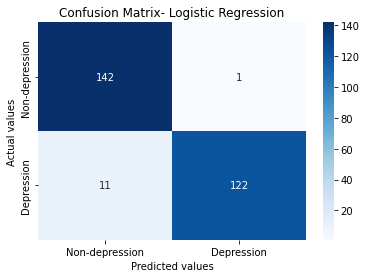

In [ ]:
print(classification_report(Y_test, new_predictions))

fpr, tpr, thresholds = metrics.roc_curve(Y_test, new_predictions, pos_label=1)
print("AUC=", metrics.auc(fpr, tpr))

# Confusion matrix
cf_matrix = confusion_matrix(Y_test, new_predictions)
categories = ['Non-depression','Depression']
sns.heatmap(cf_matrix, annot = True, cmap= 'Blues',fmt = 'd', xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.title ("Confusion Matrix- Logistic Regression")
plt.show()

#LSTM

In [ ]:
x_train = df_train['text_clean']
y_train = df_train['label']
x_test = df_test['text_clean']
y_test = df_test['label']

90% percentile is used for padding. We pad everything up to that length.

we must use the same length for test data

In [ ]:
max_len = int(np.percentile([len(instance) for instance in x_train], 90))
print(max_len)

110


The following code chunk tokenizes the tweets into tokens, then tokens to digits, and then uses padding to have the same length for each tweet.
This is required for implementing LSTM.

In [ ]:
max_words = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
train_sequences = tok.texts_to_sequences(x_train)
train_sequences_matrix = sequence.pad_sequences(train_sequences,maxlen=max_len, padding='post')   # post means do padding after the sequence

test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
print(train_sequences_matrix[0])
print(y_train[0])

[204   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
0


In [ ]:
print(train_sequences_matrix.shape)
print(test_sequences_matrix.shape)

(3217, 110)
(276, 110)


In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers import Dropout, Dense, Activation



# Set a random seed for reproducibility
np.random.seed(42)

inputs = Input((max_len, ), 
               name='word_IDs')
embeddings = Embedding(input_dim= max_words,        #?
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
#wrap the LSTM in a Bidirectional wrapper
bilstm = Bidirectional(LSTM(units=256, 
                            return_sequences=False), 
                       name="Bi-LSTM")(embeddings)
dropout = Dropout(0.3, name='dropout')(bilstm)
bilstm_out = Dense(1, name='output')(dropout)          #?
output = Activation('sigmoid', name='sigmoid')(bilstm_out)

model_bilstm = Model(inputs=[inputs], outputs=[output])
model_bilstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_IDs (InputLayer)       [(None, 110)]             0         
                                                                 
 embeddings (Embedding)      (None, 110, 128)          128000    
                                                                 
 Bi-LSTM (Bidirectional)     (None, 512)               788480    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 output (Dense)              (None, 1)                 513       
                                                                 
 sigmoid (Activation)        (None, 1)                 0         
                                                                 
Total params: 916,993
Trainable params: 916,993
Non-trainab

In [ ]:
batch_size = 16
epochs = 10

model_bilstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

In [ ]:
%%time
history_bilstm = model_bilstm.fit(train_sequences_matrix, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/10
161/161 [==============================] - 156s 921ms/step - loss: 0.2767 - accuracy: 0.8904 - val_loss: 0.1278 - val_accuracy: 0.9596
Epoch 2/10
161/161 [==============================] - 118s 732ms/step - loss: 0.0866 - accuracy: 0.9802 - val_loss: 0.1003 - val_accuracy: 0.9736
Epoch 3/10
161/161 [==============================] - 120s 743ms/step - loss: 0.0478 - accuracy: 0.9868 - val_loss: 0.0980 - val_accuracy: 0.9705
Epoch 4/10
161/161 [==============================] - 118s 730ms/step - loss: 0.0297 - accuracy: 0.9930 - val_loss: 0.1073 - val_accuracy: 0.9705
Epoch 5/10
161/161 [==============================] - 117s 724ms/step - loss: 0.0227 - accuracy: 0.9965 - val_loss: 0.1268 - val_accuracy: 0.9752
Epoch 6/10
161/161 [==============================] - 116s 722ms/step - loss: 0.0276 - accuracy: 0.9946 - val_loss: 0.1263 - val_accuracy: 0.9689
Epoch 7/10
161/161 [==============================] - 117s 726ms/step - loss: 0.0237 - accuracy: 0.9953 - val_loss: 0.1561 -

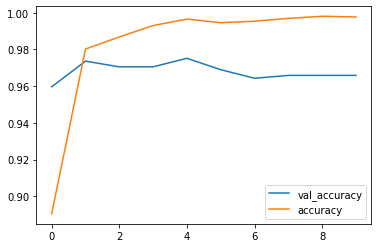

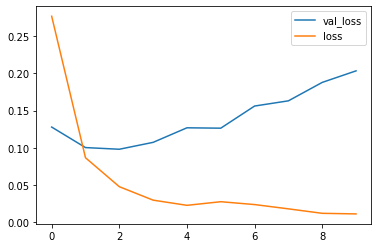

In [ ]:
df = pd.DataFrame(history_bilstm.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [ ]:
loss, accuracy = model_bilstm.evaluate(test_sequences_matrix, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

18/18 [==============================] - 2s 117ms/step - loss: 0.3097 - accuracy: 0.9601
Test loss: 0.30970481038093567
Test accuracy: 0.9601449370384216


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       143
           1       0.96      0.95      0.96       133

    accuracy                           0.96       276
   macro avg       0.96      0.96      0.96       276
weighted avg       0.96      0.96      0.96       276

AUC= 0.9758399495241601


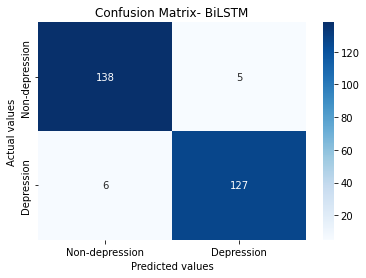

In [ ]:
predictions_bilstm = model_bilstm.predict(test_sequences_matrix)
print(classification_report(y_test, predictions_bilstm.round()))
#predictions_bilstm

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_bilstm, pos_label=1)
print("AUC=", metrics.auc(fpr, tpr))

# Confusion matrix
cf_matrix = confusion_matrix(y_test, predictions_bilstm.round())
categories = ['Non-depression','Depression']
sns.heatmap(cf_matrix, annot = True, cmap= 'Blues',fmt = 'd', xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.title ("Confusion Matrix- BiLSTM")
plt.show()

#BERT

In [ ]:
!pip install transformers
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#my data
source_folder = '/content/drive/My Drive/NLP/NLP_FinalProject/source'
destination_folder = '/content/drive/My Drive/NLP/NLP_FinalProject/destination'

In [ ]:
# Libraries

import matplotlib.pyplot as plt
import torch
from sklearn import metrics

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

This version of implementation BERT requires the three train, test, and validation dataset in which the first column should be labels and the second one the tweets to avoid any error in running the code.

In [ ]:
df_train = df_train[['label', 'text_clean']]
df_test = df_test[['label', 'text_clean']]
df_valid = df_valid[['label', 'text_clean']]

In [ ]:
# create csv files required for BERT
df_train.to_csv('/content/drive/My Drive/NLP/NLP_FinalProject/source/train.csv', index=False)
df_test.to_csv('/content/drive/My Drive/NLP/NLP_FinalProject/source/test.csv', index=False)
df_valid.to_csv('/content/drive/My Drive/NLP/NLP_FinalProject/source/valid.csv', index=False)

In [ ]:
# Model parameter
MAX_SEQ_LEN = 128    #90% - between 128 to 512
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('text_clean', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)


# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text_clean),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text_clean),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [ ]:
#BERT model
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),      #binary cross entropy loss function
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, texts), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            texts = texts.type(torch.LongTensor)  
            texts = texts.to(device)
            output = model(texts, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, texts), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        texts = texts.type(torch.LongTensor)  
                        texts = texts.to(device)
                        output = model(texts, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
%%time
train(model=model, optimizer=optimizer)

Epoch [1/5], Step [101/1010], Train Loss: 0.2947, Valid Loss: 0.1100
Model saved to ==> /content/drive/My Drive/NLP/NLP_FinalProject/destination/model.pt
Model saved to ==> /content/drive/My Drive/NLP/NLP_FinalProject/destination/metrics.pt
Epoch [1/5], Step [202/1010], Train Loss: 0.1298, Valid Loss: 0.8692
Epoch [2/5], Step [303/1010], Train Loss: 0.1553, Valid Loss: 0.0782
Model saved to ==> /content/drive/My Drive/NLP/NLP_FinalProject/destination/model.pt
Model saved to ==> /content/drive/My Drive/NLP/NLP_FinalProject/destination/metrics.pt
Epoch [2/5], Step [404/1010], Train Loss: 0.0805, Valid Loss: 1.3021
Epoch [3/5], Step [505/1010], Train Loss: 0.1322, Valid Loss: 0.0577
Model saved to ==> /content/drive/My Drive/NLP/NLP_FinalProject/destination/model.pt
Model saved to ==> /content/drive/My Drive/NLP/NLP_FinalProject/destination/metrics.pt
Epoch [3/5], Step [606/1010], Train Loss: 0.0684, Valid Loss: 0.2790
Epoch [4/5], Step [707/1010], Train Loss: 0.1002, Valid Loss: 0.0491
M

Model loaded from <== /content/drive/My Drive/NLP/NLP_FinalProject/destination/metrics.pt


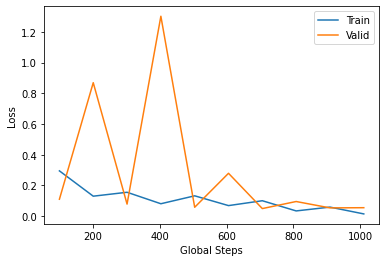

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, texts), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                texts = texts.type(torch.LongTensor)  
                texts = texts.to(device)
                output = model(texts, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix- BERT')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Depression', 'Non-depression'])
    ax.yaxis.set_ticklabels(['Depression', 'Non-depression'])
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    print("AUC=", metrics.auc(fpr, tpr))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/My Drive/NLP/NLP_FinalProject/destination/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9921    0.9474    0.9692       133
           0     0.9530    0.9930    0.9726       143

    accuracy                         0.9710       276
   macro avg     0.9726    0.9702    0.9709       276
weighted avg     0.9719    0.9710    0.9710       276

AUC= 0.9701877070298123


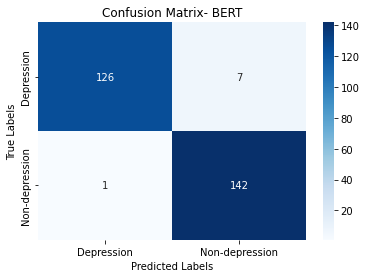

In [ ]:
best_model = BERT().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=2e-5)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)